In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.utils.data as data 

from omegaconf import OmegaConf
from torchvision import transforms
from torch.nn.parallel import DistributedDataParallel as DDP

from contrastive_learning.tests.test_model import get_closest_embeddings, save_all_embeddings, load_encoder
from contrastive_learning.models.pretrained_models import resnet18
from contrastive_learning.datasets.dataset import Dataset, get_dataloaders



In [9]:
# Start the multiprocessing to load the saved models properly
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29504"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)

RuntimeError: trying to initialize the default process group twice!

In [3]:
# Set the device and out_dir
device = torch.device('cuda:0')
# out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.06/resnet18_mlp'
out_dir = '/home/irmak/Workspace/DAWGE/contrastive_learning/out/2022.07.07/01-14_resnet18_mlp_pretrained_false'
encoder_path = os.path.join(out_dir, 'models/encoder.pt')

# Load the encoder
encoder = load_encoder(device, encoder_path, encoder_type='resnet18')


In [4]:
# Get the test dataloader and pass all observations to get save embeddings
cfg = OmegaConf.load('/home/irmak/Workspace/DAWGE/contrastive_learning/configs/train.yaml')

dataset = Dataset(data_dir=cfg.data_dir, frame_interval=cfg.frame_interval)
data_loader = data.DataLoader(dataset, batch_size=16, shuffle=False,
                                    num_workers=4, sampler=None)
# train_loader, test_loader, train_dset, test_dset = get_dataloaders(cfg)
len_dset = len(dataset)
z_dim = cfg.z_dim 

In [5]:
save_all_embeddings(
    device = device,
    len_dset = len_dset, 
    z_dim = z_dim, 
    encoder = encoder,
    train_loader = data_loader, # TODO: change this parameter's name
    out_dir = out_dir
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 118/118 [00:16<00:00,  7.17it/s]


In [7]:
# Get random images from test loader, plot them with matplotlib and find the closest KNNs
inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                    std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                    std = [ 1., 1., 1. ]),
                                ])

data_loader = data.DataLoader(dataset, batch_size=16, shuffle=True,
                                    num_workers=4, sampler=None)


batch = next(iter(data_loader))
obs, _, _ = [b.to(device) for b in batch]
bs = obs.shape[0] 
obs = inv_trans(obs)
act_obs = obs.permute(0,2,3,1).cpu() # actual observations ready to plot

# Get the test observations in the test embeddings
k = 5
test_obs_idx = np.zeros((bs, k))
for i in range(bs):
    curr_obs = obs[i:i+1] if i < bs-1 else obs[i:]
    act_obs_id = get_closest_embeddings(
        out_dir = out_dir, 
        encoder = encoder,
        obs = curr_obs,
        k = k
    )
    test_obs_idx[i] = act_obs_id

# Get actual observations
test_obs = np.zeros((bs, k, act_obs.shape[1], act_obs.shape[2], act_obs.shape[3]))
print('test_obs.shape: {}'.format(test_obs.shape))
for i in range(bs):
    for j,kth_index in enumerate(test_obs_idx[i]):
        curr_obs, _, _ = dataset.getitem(int(kth_index))
        curr_obs = inv_trans(curr_obs)
        test_obs[i,j] = curr_obs.permute(1,2,0)


closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
closest_z_idx.shape: (5,)
test_obs.shape: (16, 5, 480, 480, 3)


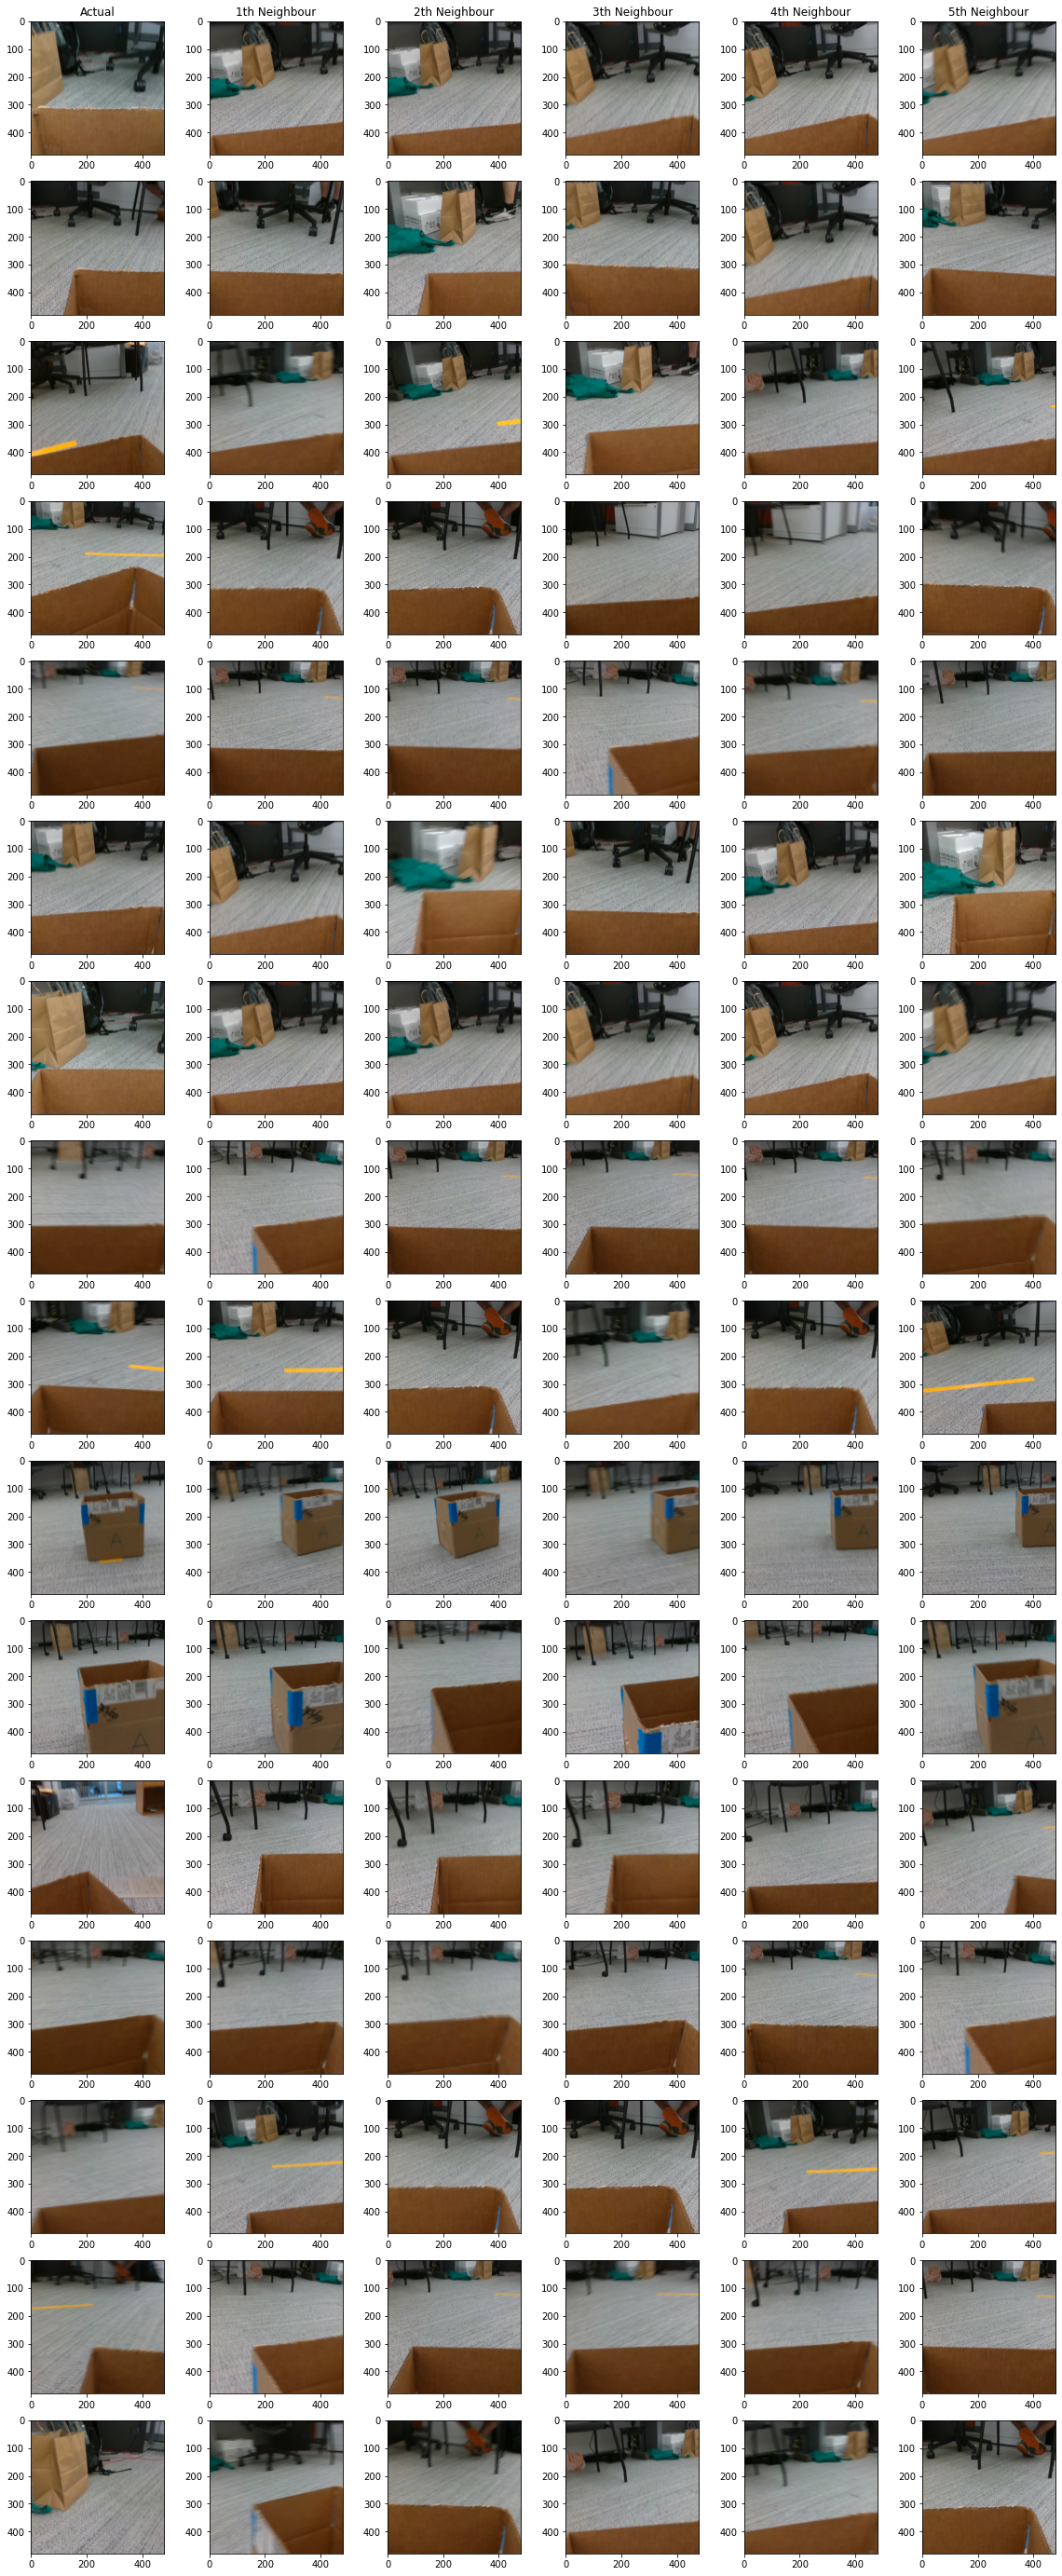

In [8]:
# Plot act_obs and test_obs
fig, axs = plt.subplots(figsize=(20,50), nrows=bs, ncols=k+1) # TODO: you can increase this as you trained more

# Name the columns
axs[0][0].set_title("Actual")
for i in range(k):
    axs[0][i+1].set_title(f"{i+1}th Neighbour")

# Save act_obs to the first column
for i in range(bs):
    axs[i][0].imshow(act_obs[i])
    # Plot the test obs
    for j in range(k):
        axs[i][j+1].imshow(test_obs[i,j])

plt.savefig(os.path.join(out_dir, 'resnet18_mlp_encoder_test.jpg'))
